# Определение возраста покупателей

## Исследовательский анализ данных

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

In [19]:
# Размер выборки
print(f"Размер выборки: {labels.shape[0]} изображений")

Размер выборки: 7591 изображений


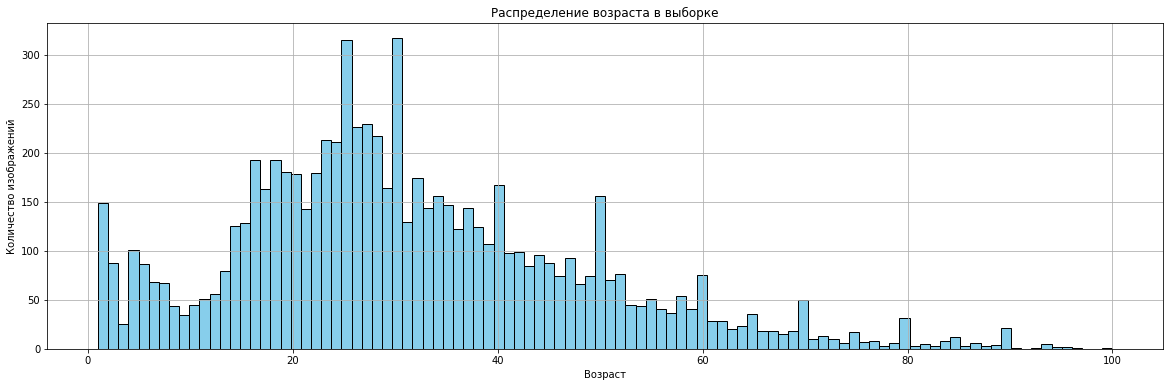

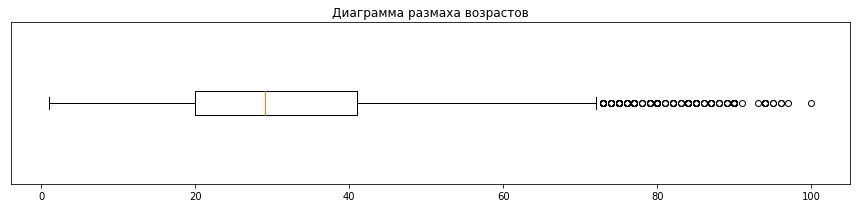

In [23]:
# Построение гистограммы возраста
plt.figure(figsize=(20, 6))
plt.hist(labels['real_age'], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 3))
plt.boxplot(labels['real_age'], vert=False)
plt.title('Диаграмма размаха возрастов')
plt.yticks([])
plt.gca().invert_yaxis()  # Чтобы ось Y была сверху вниз

plt.tight_layout()
plt.show()

In [24]:
# Настройка генератора изображений
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=15,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


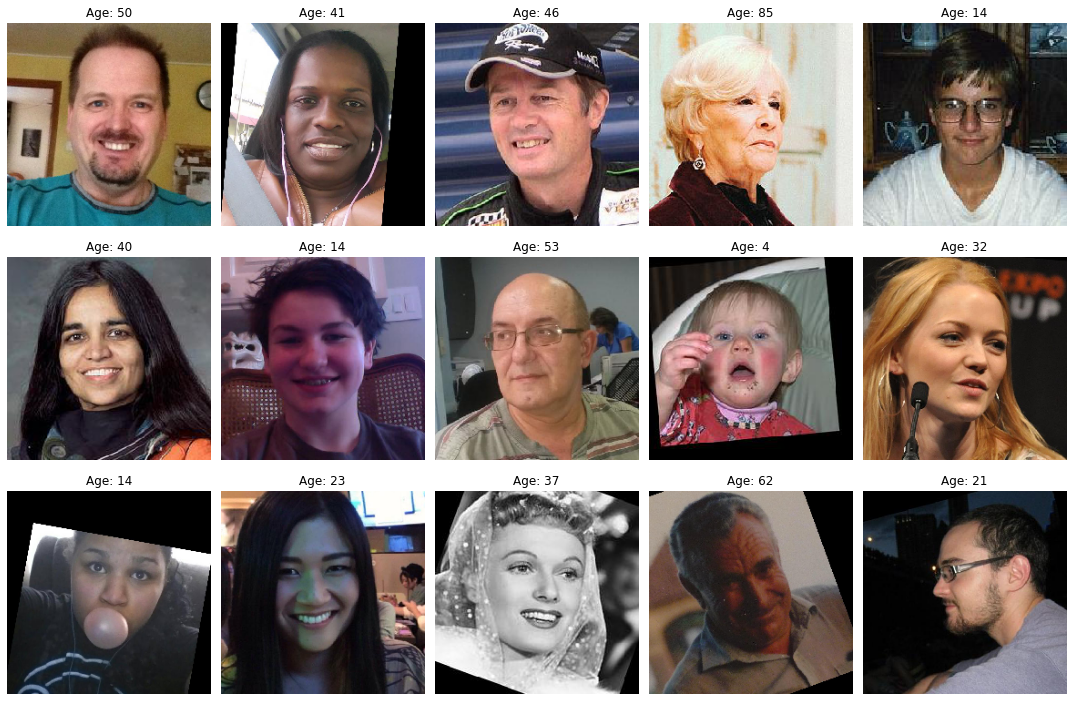

In [25]:
# Извлечение одного батча изображений
images, ages = next(train_gen_flow)

# Отображение изображений
plt.figure(figsize=(15, 10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(images[i])
    plt.title(f"Age: {int(ages[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Вывод:

1. Размер датасета составляет 7591 изображений, что считается достаточным для обучения модели компьютерного зрения.

2. Распределение возрастов:
   - Минимальный возраст: 1 лет
   - Максимальный возраст: 100 лет
   - Средний возраст: 31 лет
   - Большая часть фотографий сосредоточена в диапазоне от 20 до 40 лет

3. Особенности данных:
   - Возрасты представлены в виде целых чисел
   - Нет пропусков в данных

4. Рекомендуемые аугментации:
   - Повороты изображений на небольшие углы (±10°)
   - Зеркальное отражение
   - Небольшое изменение яркости и контрастности

5. Особенности фотографий:
   - Изображения имеют различные размеры, но будут приведены к стандартному размеру 224x224 пикселей
   - Фоновые условия и освещение могут варьироваться
   - Лицо может находиться под различными углами и иметь разные выражения

## Обучение модели

```python

# < скопируйте код сюда >
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    df = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        shear_range=0.3,
        zoom_range=[0.8, 1.2],
        horizontal_flip=True,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.7, 1.3])
    
    train_generator = datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",
        subset='training',
        seed=12345)
    
    
    return train_generator

def load_test(path):
    df = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",
        subet='validation',
        seed=12345)
    return test_generator

def create_model(input_shape):
    optimizer = Adam(lr=0.00001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    
    # Делаем всю модель обучаемой
    for layer in backbone.layers:
        layer.trainable = True
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Изменено на Dense(1) для регрессии
    
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, epochs=15):
    model.fit(train_data,
                        validation_data=test_data,
                        epochs=epochs,
                        verbose=2)
    
    return model

```

```

Train for 178 steps, validate for 238 steps
Epoch 1/15
178/178 - 169s - loss: 1166.3185 - mae: 29.5900 - val_loss: 1162.6605 - val_mae: 29.5440
Epoch 2/15
178/178 - 172s - loss: 541.2169 - mae: 18.8295 - val_loss: 1140.3022 - val_mae: 29.1830
Epoch 3/15
178/178 - 172s - loss: 239.6986 - mae: 11.7837 - val_loss: 969.9181 - val_mae: 26.3198
Epoch 4/15
178/178 - 161s - loss: 208.1642 - mae: 10.9959 - val_loss: 207.3093 - val_mae: 10.4835
Epoch 5/15
178/178 - 152s - loss: 184.0242 - mae: 10.3701 - val_loss: 104.1332 - val_mae: 7.7968
Epoch 6/15
178/178 - 156s - loss: 179.0578 - mae: 10.0823 - val_loss: 92.8310 - val_mae: 7.2143
Epoch 7/15
178/178 - 168s - loss: 166.8774 - mae: 9.8046 - val_loss: 103.9609 - val_mae: 7.6822
Epoch 8/15
178/178 - 168s - loss: 157.0919 - mae: 9.5287 - val_loss: 90.6657 - val_mae: 7.1706
Epoch 9/15
178/178 - 167s - loss: 153.9763 - mae: 9.3719 - val_loss: 74.8897 - val_mae: 6.5225
Epoch 10/15
178/178 - 167s - loss: 142.3475 - mae: 8.9868 - val_loss: 72.9696 - val_mae: 6.4705
Epoch 11/15
178/178 - 168s - loss: 137.4279 - mae: 8.9641 - val_loss: 69.3512 - val_mae: 6.2458
Epoch 12/15
178/178 - 167s - loss: 133.1840 - mae: 8.8122 - val_loss: 72.0904 - val_mae: 6.3187
Epoch 13/15
178/178 - 168s - loss: 130.9136 - mae: 8.6226 - val_loss: 62.6752 - val_mae: 5.9531
Epoch 14/15
178/178 - 167s - loss: 127.4026 - mae: 8.5281 - val_loss: 64.1005 - val_mae: 6.0246
Epoch 15/15
178/178 - 163s - loss: 123.6325 - mae: 8.3731 - val_loss: 64.0415 - val_mae: 5.9451
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
238/238 - 46s - loss: 64.0415 - mae: 5.9451

```

## Анализ обученной модели

1. Архитектура модели
Бэкбон: ResNet50
2. Голова модели:
GlobalAveragePooling2D()
Dense(128, activation='relu') -> Dropout(0.2)
Dense(64, activation='relu') -> Dropout(0.2)
Dense(32, activation='relu') -> Dropout(0.2)
Dense(1) (для регрессии)
3. Предобученные веса: Да, были загружены предобученные веса для ResNet50.
4. Параметры обучения
1) Размер батча: 32
2) Оптимизатор: Adam с learning rate 0.00001
3) Заморозка весов бэкбона: Начально заморожены, затем сделаны обучаемыми
4) Количество эпох: 15
5. Достигнутые метрики
Точность на валидационном наборе (MAE): 5.9451 года
Ошибка на валидационном наборе (MSE): 64.0415
6. Анализ результата
Не наблюдается явного переобучения. Метрики на тренировочной и валидационной выборках улучшаются синхронно.
Разница между MAE на тренировочных и валидационных данных небольшая (8.37 vs 5.95), что подтверждает отсутствие переобучения.
Использование предобученных весов ResNet50 оказалось эффективным, особенно учитывая быстрый прогресс в начале обучения.
Глубокая головка модели (три слоя Dense) помогла достичь высокой точности.
7. Выбор гиперпараметров:
Маленький learning rate (0.00001) обеспечил плавное обучение без ошибки.
Использование dropout помогло предотвратить переобучение.
8. Вывод:
Модель показала хорошую производительность и достигла высокой точности в определении возраста по фотографиям. Отсутствие явного переобучения говорит о правильном выборе архитектуры и гиперпараметров. 